=======================Dataloader========================
Data Loaded already!!
=======================Interest points detection & feature description========================
img1 shape is (640, 480, 3)
img2 shape is (640, 480, 3)

 *Use orb to  detect Interest points and feature description

Image 1 find 422 key points
Image 1 descriptor size is (422, 128)
Image 2 find 429 key points
Image 2 descriptor size is (429, 128)
Step 1 cost 0.06615328788757324 secods
=======================Feature matching by features========================


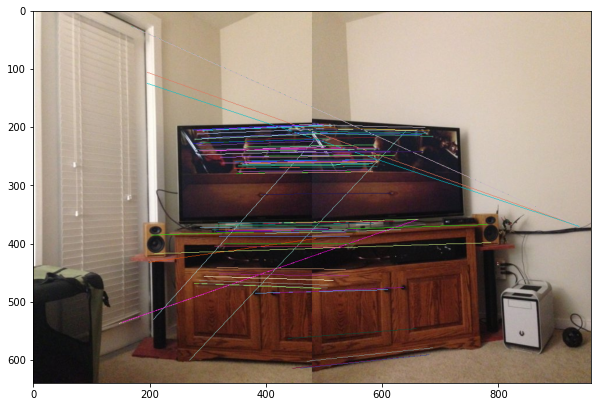

Step 2 Cost 7.706686973571777 seconds
=======================RANSAC to find homography matrix H========================


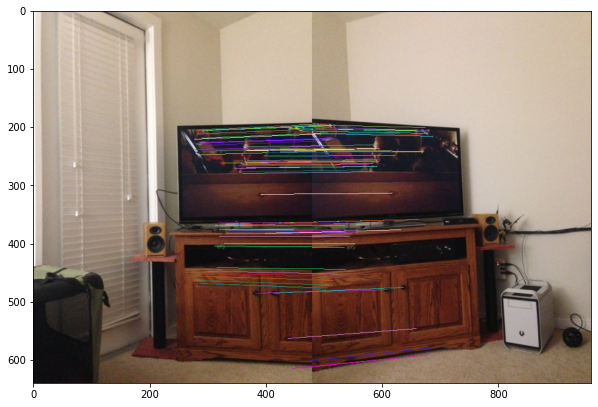

Step 3 cost 0.3329446315765381 seconds
=======================Warp image to create panoramic image========================


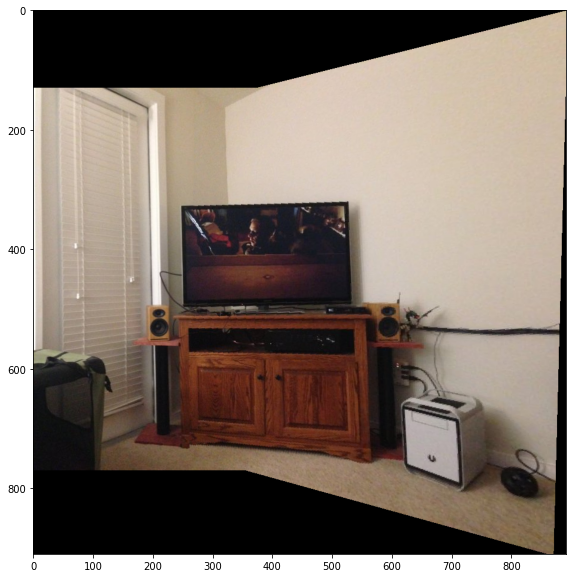

Stpe 4 cost 51.05680513381958 seconds


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import heapq
import time
import random

def show(image):
    plt.figure(figsize=(10,10))
    image = image[:,:,::-1]
    plt.clf()
    plt.imshow(image)
    #plt.axis('off')
    plt.show()

    
    
def Kp_and_Feature_Des(data1_path, data2_path, method):
    img1 = cv2.imread(data1_path)
    img2 = cv2.imread(data2_path)    
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    while(img2.shape[0] > 1000):
        img1 = cv2.resize(img1,None,fx=0.5, fy=0.5)
        img1_gray = cv2.resize(img1_gray,None,fx=0.5, fy=0.5)
        img2 = cv2.resize(img2,None,fx=0.5, fy=0.5)
        img2_gray = cv2.resize(img2_gray,None,fx=0.5, fy=0.5)
    
    print(f"img1 shape is {img1.shape}")
    print(f"img2 shape is {img2.shape}")
        
    # Scale-Invariant Feature Transform
    if method == 'sift':
        sift = cv2.xfeatures2d.SIFT_create()
        kp1, des1 = sift.detectAndCompute(img1_gray, None)
        kp2, des2 = sift.detectAndCompute(img2_gray, None)  
    
    
    # Speeded-Up Robust Features
    if method == 'surf':
        surf = cv2.xfeatures2d.SIFT_create()
        kp1, des1 = surf.detectAndCompute(img1_gray, None) 
        kp2, des2 = surf.detectAndCompute(img2_gray, None)
        
    # Oriented FAST and Rotated BRIEF
    if method == 'orb':
        orb = cv2.xfeatures2d.SIFT_create()
        kp1, des1 = orb.detectAndCompute(img1_gray, None)
        kp2, des2 = orb.detectAndCompute(img2_gray, None)
    
    return kp1, kp2, des1, des2, img1, img2
    
def Matching(Descriptors1, Descriptors2, threshold):
    Best_Match = -1 * np.ones(Descriptors1.shape[0],dtype = int)
    for i in range(Descriptors1.shape[0]):
        Score = []
        for j in range(Descriptors2.shape[0]):
            diff = Descriptors1[i] - Descriptors2[j]
            diff = diff**2
            diff = sum(diff)
            Score.append(diff)
        min_num_index_list = map(Score.index, heapq.nsmallest(2, Score))
        First , Second = list(min_num_index_list)
        f1 = Descriptors1[i]
        f2 = Descriptors2[First]
        f2_ = Descriptors2[Second]
        
        ratio_distance = np.sqrt(sum((f1 - f2)**2)) / np.sqrt(sum((f1 - f2_)**2))
        if ratio_distance < threshold:
            Best_Match[i] = First
        
    return Best_Match

def Combine(img1, img2, Best_Match, Key_Point1, Key_Point2):
    ha, wa = img1.shape[:2]
    hb, wb = img2.shape[:2]
    combine = np.zeros((max(ha, hb), wa + wb, 3), dtype="uint8")
    combine[0:ha, 0:wa] = img1
    combine[0:hb, wa:] = img2
    #show(combine)
    
    for i in range(len(Best_Match)):
        if Best_Match[i]!=-1:
            color = np.random.randint(0, high = 255, size = (3,))
            color = (int(color[0]), int(color[1]), int(color[2]))
            ptA = int(Key_Point1[i].pt[0]), int(Key_Point1[i].pt[1])
            ptB = int(Key_Point2[Best_Match[i]].pt[0] + wa), int(Key_Point2[Best_Match[i]].pt[1] )
            cv2.line(combine, ptA, ptB, color, 1)
    show(combine)
    
def Combine1(img1, img2,Inner_group1, Inner_group2):
    ha, wa = img1.shape[:2]
    hb, wb = img2.shape[:2]
    combine = np.zeros((max(ha, hb), wa + wb, 3), dtype="uint8")
    combine[0:ha, 0:wa] = img1
    combine[0:hb, wa:] = img2
    #show(combine)
    
    for i in range(len(Inner_group1)):
        color = np.random.randint(0, high = 255, size = (3,))
        color = (int(color[0]), int(color[1]), int(color[2]))
        ptA = int(Inner_group1[i,0]) , int(Inner_group1[i,1])
        ptB = int(Inner_group2[i,0]  + wa), int(Inner_group2[i,1])
        cv2.line(combine, ptA, ptB, color, 1)
    show(combine)
    
def Find_Good_pairs(Key_Point1, Key_Point2, Best_Match, repeat_times, random_number, threshold):
    max_count = -1
    
    Point1_array = []
    Key_Point1 = np.array(Key_Point1)
    for i in range(len(Key_Point1)):
        temp = Key_Point1[i].pt
        Point1_array.append(temp)
    Point1_array = np.array(Point1_array)
    Point2_array = []
    Key_Point2 = np.array(Key_Point2)
    for i in range(len(Key_Point2)):
        temp = Key_Point2[i].pt
        Point2_array.append(temp)
    Point2_array = np.array(Point2_array)
    index = np.where(Best_Match!=-1)
    
    Point2_array_cp = np.copy(Point2_array).T
    
    temp = np.ones((1,Point2_array_cp.shape[1]))
    Point2_array_cp = np.concatenate((Point2_array_cp,temp),axis = 0)


    for i in range(repeat_times):
        random_pick = random.sample(list(index[0]), random_number)
        Image1_point = Point1_array[random_pick].T
        Image2_point = Point2_array[Best_Match[random_pick]].T
        temp = np.ones((1,random_number))
        Image2_point = np.concatenate((Image2_point,temp),axis = 0)
        Affin_Matrix = np.dot(Image1_point, np.linalg.pinv(Image2_point))
        Image2_point = np.dot(Affin_Matrix, Point2_array_cp).T

        diff = np.sqrt((np.sum((Point1_array[index] - Image2_point[Best_Match[index]])**2, axis = 1)))
        diff_1 = diff[diff<threshold]
        if len(diff_1) > max_count:
            max_count = len(diff_1)
            Inner_group1 = Point1_array[index]
            Inner_group2 = Point2_array[Best_Match[index]]
            Inner_group1 = Inner_group1[diff<threshold]
            Inner_group2 = Inner_group2[diff<threshold]
    return Inner_group1, Inner_group2

def Find_Homography(group1, group2):
    P = np.zeros((2*len(group1),9))
    temp = np.ones((len(group1),1))
    group1 = np.concatenate((group1,temp), axis = 1)
    group2 = np.concatenate((group2,temp), axis = 1)
    for i in range(len(group1)):
        P[2*i,0:3] = group2[i]
        P[2*i + 1,3:6] = group2[i]
        P[2*i,6:9] = -group1[i,0] * group2[i]
        P[2*i + 1,6:9] = -group1[i,1] * group2[i]
    
    U , sigma , V_T = np.linalg.svd(P)
    V = V_T.T
    h = V[:,-1].reshape(3,3)
    h = h / h[2,2]
    return h
    
def warp(img1, img2, H):
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corner_img2 = np.zeros((4, 2), np.int32)

    warp = np.zeros((4, 3))
    warp[0] = H.dot(np.array([0, 0, 1]))
    warp[1] = H.dot(np.array([w2-1, 0, 1]))
    warp[2] = H.dot(np.array([0, h2-1, 1]))
    warp[3] = H.dot(np.array([w2-1, h2-1, 1]))  
    for i in range(4):
        corner_img2[i] = warp[i][:2] // warp[i][2] 
    rectangleMin = corner_img2.min(0) ##axis =0
    rectangleMax = corner_img2.max(0) ##axis =0
    
    offset_min = (min(rectangleMin[0], 0), min(rectangleMin[1], 0))
    offset_max = (max(rectangleMax[0], w1, w2), max(rectangleMax[1], h1, h2))
    
    output = np.full((offset_max[1] - offset_min[1], offset_max[0] - offset_min[0], 3), 0, np.uint8)
    output[-offset_min[1]:-offset_min[1] + h1, -offset_min[0]:-offset_min[0] + w1,:] = img1
        
    for b in range(rectangleMin[1], rectangleMax[1]):
        for a in range(rectangleMin[0], rectangleMax[0]):
            for k in range(3):
                invH = np.linalg.inv(H)
                match2org_ = invH.dot([a, b, 1])
                match2org = (match2org_[:2] // match2org_[2]).astype(np.int32)

                if (match2org[1] >= 0 and match2org[1] < h2) and (match2org[0] >= 0 and match2org[0] < w2):
                    output[b-offset_min[1], a-offset_min[0], k] = img2[match2org[1], match2org[0], k]


#     cv2.circle(output, (corner[0][0] + w_middle, corner[0][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[1][0] + w_middle, corner[1][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[2][0] + w_middle, corner[2][1] + h_middle), 4, (0, 0, 255), 4)
#     cv2.circle(output, (corner[3][0] + w_middle, corner[3][1] + h_middle), 4, (0, 0, 255), 4)
    show(output)
    return output

    
if __name__ == "__main__":
    ### Dataloader
    print("=======================Dataloader========================")
    data1_path = './data/1.jpg'
    data2_path = './data/2.jpg'

    print ("Data Loaded already!!")
    
    ### step 1
    print("=======================Interest points detection & feature description========================")
    start = time.time()
    ### Can set the detecting and feature description method with method sift surf orb
    method = 'orb'
    Key_Point1 ,Key_Point2 , Descriptors1, Descriptors2, img1, img2 = Kp_and_Feature_Des(data1_path,data2_path,method)

    
    end = time.time()
    
    #img1 = cv2.drawKeypoints(img1, Key_Point1, img1)
    #img2 = cv2.drawKeypoints(img2, Key_Point2, img2)

    print(f"\n *Use {method} to  detect Interest points and feature description\n")
    print(f"Image 1 find {len(Key_Point1)} key points")
    print(f"Image 1 descriptor size is {Descriptors1.shape}")
    print(f"Image 2 find {len(Key_Point2)} key points")
    print(f"Image 2 descriptor size is {Descriptors2.shape}")
    print(f"Step 1 cost {end-start} secods")
    
    ### step 2
    print("=======================Feature matching by features========================")
    start = time.time()
    threshold = 0.7
    Best_Match = Matching(Descriptors1, Descriptors2, threshold)
    Combine(img1, img2, Best_Match, Key_Point1, Key_Point2)
    end = time.time()
    print(f"Step 2 Cost {end-start} seconds")
    
    
    ### step 3
    print("=======================RANSAC to find homography matrix H========================")
    start = time.time()
    repeat_times = 1000
    random_number = 3
    threshold = 20
    Inner_group1, Inner_group2 = Find_Good_pairs(Key_Point1, Key_Point2, Best_Match, repeat_times, random_number, threshold)
    
    Combine1(img1, img2,Inner_group1, Inner_group2)

    Homography = Find_Homography(Inner_group1, Inner_group2)
    end = time.time()
    print(f"Step 3 cost {end-start} seconds")
    
    
    ### step 4
    print("=======================Warp image to create panoramic image========================")
    start = time.time()
    warp(img1, img2,Homography)
    end = time.time()
    print(f"Stpe 4 cost {end-start} seconds")
    
    